Using Longitudinal Data
=======================

This example demonstrates how to do cross validation with longitudinal
data.
By *longitudinal*, we mean predictors for specific samples that have more than one value. 
This could be time series data or any other sequential data we might want to model. 


Example Patient Data
------------------------------

First, we generate some example data and store it using this script: https://github.com/lacava/feat/blob/master/docs/examples/longitudinal/generate_example_longitudinal_data.py. 

Let’s imagine we have patient data from a hospital. 
This means we have measurements from different visits, with different numbers of measurements from different
patients collected in non-uniform intervals.
In this example, we make up a risk model in which risk increases for a
patient with an increasing body mass index (BMI) and a high maximum
glucose level in their blood panel.

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold

random_state=42

df = pd.read_csv('data/d_example_patients.csv')
df.drop('id',axis=1,inplace=True)
X = df.drop('target',axis=1)
y = df['target']
zfile = 'data/d_example_patients_long.csv'
kf = KFold(n_splits=3,shuffle=True,random_state=random_state)


Next we set up the learner. We need to declare the longitudinal
operators we want to search over. They are defined as a comma-delimited
list of strings using the ``functions`` argument. In this case, the
operators on the second row of the declaration below all operate on
longitudinal data.


In [2]:
from feat import Feat

clf = Feat(max_depth=5,
           max_dim=5,
           gens = 100,
           pop_size = 100,
           max_time = 30, # seconds
           verbosity=2,
           shuffle=True,
           normalize=False, # don't normalize input data
           functions="and,or,not,split,split_c,"
                     "mean,median,max,min,variance,skew,kurtosis,slope,count",
           backprop=True,
           batch_size=10,
           iters=10,
           random_state=random_state,
           n_jobs=1,
           simplify=0.01    # prune final representations
          )


Cross validation
----------------

Cross validation works a little bit differently with longitudinal data. 
The block below shows how to train a model using Kfold cross validation.

In [3]:
scores=[]

for train_idx, test_idx in kf.split(X,y):
    # print('train_idx:',train_idx)
    # note that the train index is passed to FEAT's fit method
    clf.fit(X.loc[train_idx],y.loc[train_idx],zfile,train_idx) 
    scores.append(clf.score(X.loc[test_idx],y.loc[test_idx],zfile,test_idx))

print('scores:',scores)

scores: [0.0019200502112349603, 0.0013323824931506492, 0.020377830997444116]


Model Interpretation
--------------------

Now let’s fit a model to all the data and try to interpret it.


In [4]:
# fit to all data

print('fitting longer to all data...')
clf.verbosity = 2
clf.fit(X,y,zfile,np.arange(len(X)))

fitting longer to all data...


Feat(backprop=True, batch_size=10, feature_names='sex,race',
     functions='and,or,not,split,split_c,mean,median,max,min,variance,skew,kurtosis,slope,count',
     max_depth=5, max_dim=5, max_time=30, normalize=False, random_state=42,
     simplify=0.01, verbosity=2)


To see the learned representation, we run ``clf.get_representation()``:

In [5]:
clf.get_representation()

'[slope(z_bmi)][max(z_glucose)]'

Here our final representation is composed of ``slope(z_bmi)`` and
``max(z_glucose)``, both of which we know to be correct features for
this simulated dataset. The best training representation displays clear
overfitting, highlighting the importance of using archive validation for
model selection.
We can also look at the representation with the model weights, sorted by
magnitude, using ``clf.get_model()``:

In [6]:
print(clf.get_model())

Weight	Feature
8.23132	offset
0.80	slope(z_bmi)
0.73	max(z_glucose)



View runtime stats
------------------

FEAT stores statistics about the training procedure in a dictionary `clf.stats_`. 
An example of plotting from this dictionary is shown below.

In [7]:
clf.stats_.keys()

dict_keys(['generation', 'med_complexity', 'med_dim', 'med_loss', 'med_loss_v', 'med_num_params', 'med_size', 'min_loss', 'min_loss_v', 'time'])

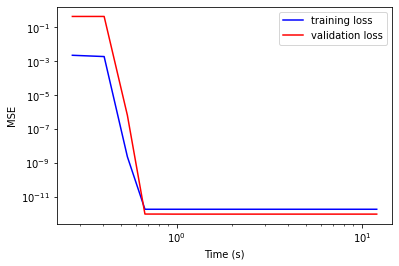

In [8]:
import matplotlib.pyplot as plt
plt.plot(clf.stats_['time'], clf.stats_['min_loss'], 'b', label='training loss')
plt.plot(clf.stats_['time'], clf.stats_['min_loss_v'], 'r', label='validation loss')
plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('MSE')
plt.gca().set_yscale('log')
plt.gca().set_xscale('log')

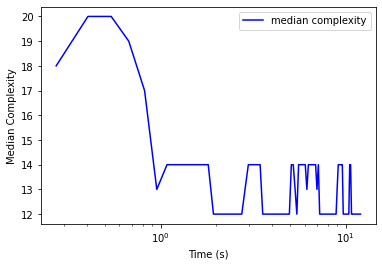

In [9]:
import matplotlib.pyplot as plt
plt.plot(clf.stats_['time'], clf.stats_['med_complexity'], 'b', label='median complexity')
# plt.plot(clf.stats_['time'], clf.stats_['med_size'], 'r', label='median size')
plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('Median Complexity')
# plt.gca().set_yscale('log')
plt.gca().set_xscale('log')

Visualizing the representation
------------------------------

Here we take the two relevant features and plot the data with them.
This shows us the risk surface as a function of these learned features.

proj: (993, 2)
rep: ['slope(z_bmi)', 'max(z_glucose)']


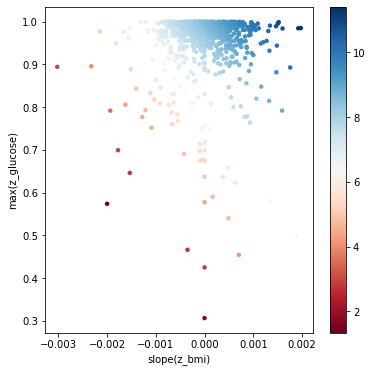

In [10]:
# Visualize the representation

proj = clf.transform(X,zfile,np.arange(len(X)))

print('proj:',proj.shape)
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patheffects as PathEffects
from matplotlib import cm

cm = plt.cm.get_cmap('RdBu')
# We choose a color palette with seaborn.
# palette = np.array(sns.color_palette("cividis", np.unique(y)))

# We create a scatter plot.
f = plt.figure(figsize=(6, 6))
ax = plt.subplot(aspect='equal')
sc = ax.scatter(proj[:,0], proj[:,1], lw=0, s=20,
                c=y, cmap=cm)
plt.colorbar(sc)
# sc.colorbar()
ax.axis('square')
# ax.axis('off')
ax.axis('tight')

# add labels from representation
rep = [r.split('[')[-1] for r in clf.get_representation().split(']') if r != '']
print('rep:',rep)
plt.xlabel(rep[0])
plt.ylabel(rep[1])

# plt.savefig('longitudinal_representation.svg', dpi=120)
plt.show()